In [163]:
import pandas as pd
import openai
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.getenv('OPENAI_API_KEY')
import json
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

In [164]:
def get_completion(prompt, model="gpt-3.5-turbo",temperature=0): # Andrew mentioned that the prompt/ completion paradigm is preferable for this class
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

In [170]:
with open('asrOutput_2.json', 'r') as f:
  data = json.load(f)


In [171]:
data

{'jobName': 'TranscribeAudio-2p.mp3-1689306852.218444',
 'accountId': '689813869550',
 'results': {'transcripts': [{'transcript': 'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. A cuál es el problema exactamente? Puede darme más detalles? Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude. Ok, entiendo. Eso es una preocupante. Y cómo puedo estar seguro de que realmente estás llamando desde mi banco? Y no se trata de una estafa, eh? Mira, por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general. Ok? Si ese es el caso, eh, Por favor dame el número del del banco para que yo pueda llamar directamente y verificar la situación. Ok? Eh, somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.'}],
  'speak

In [172]:
df = pd.DataFrame(data['results']['items'])

In [173]:
df['confidence'] = df.alternatives.map(lambda x: x[0]['confidence'])
df['content'] = df.alternatives.map(lambda x: x[0]['content'])

In [174]:
df

,start_time,speaker_label,end_time,alternatives,type,confidence,content
0,0.469,spk_0,0.819,"[{'confidence': '0.999', 'content': 'Hola'}]",pronunciation,0.999,Hola
1,NaN,spk_0,NaN,"[{'confidence': '0.0', 'content': '.'}]",punctuation,0.0,.
2,1.019,spk_0,1.22,"[{'confidence': '0.998', 'content': 'Soy'}]",pronunciation,0.998,Soy
3,1.23,spk_0,1.86,"[{'confidence': '0.995', 'content': 'represent...",pronunciation,0.995,representante
4,1.87,spk_0,1.96,"[{'confidence': '0.997', 'content': 'de'}]",pronunciation,0.997,de
...,...,...,...,...,...,...,...
164,55.279,spk_0,55.34,"[{'confidence': '0.992', 'content': 'a'}]",pronunciation,0.992,a
165,55.349,spk_0,55.63,"[{'confidence': '0.984', 'content': 'través'}]",pronunciation,0.984,través
166,55.639,spk_0,55.79,"[{'confidence': '0.983', 'content': 'del'}]",pronunciation,0.983,del
167,55.799,spk_0,56.24,"[{'confidence': '0.996', 'content': 'teléfono'}]",pronunciation,0.996,teléfono


In [213]:
df_s0 = df[df['speaker_label'] == 'spk_0'].reset_index()

In [236]:
scam_text = ' '.join(df.content).replace(' .', '.').replace(' ,', ',').replace(' ?', '?').replace(' !', '!')
scam_text

'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude. Ok, eh? Mira, por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general. Ok? Eh, somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.'

In [258]:

formato_json = """
{
  "score": ,
  "frases_clave_scam": [
    {
      "phrase": ,
      "score_scam": ,
      "justificacion": ,
      "recomendacion": ,
      "sentimiento": ,
      "index_texto": ()
    },
    {
      "phrase": ,
      "score_scam": ,
      "justificacion": ,
      "sentimiento": ,
      "index_texto": (indice de inicio, indice final)
    }
  ],
}"""
prompt = f"""
Imagina que eres un modelo de inteligencia artificial de "scam detector". Évalua el siguiente texto entre comillas simples '{scam_text}' . 
1- Genera un score de un solo número del 1 al 100 y una lista de frases clave pequeñas del texto de scam con su score de scam. 
2- Identifica las frases potencialmente fraudulentas: 
  2.1- justifica el score asignado en 10 palabras. 
  2.2- Agrega recomendiaciones particulares para cada frase.
  2.3- Agrega el sentimiento de cada frase en "Positivo", "Negativo"
4- Muestras los resultados en formato json con este formato: {formato_json}, en español.
"""
response = get_completion(prompt)
print(response)

{
  "score": 85,
  "frases_clave_scam": [
    {
      "phrase": "Hay un problema con su cuenta y necesitamos verificar su información de inmediato.",
      "score_scam": 90,
      "justificacion": "Solicita información personal de forma urgente y sin previo aviso.",
      "recomendacion": "No proporcione información personal sin verificar la autenticidad de la llamada o mensaje.",
      "sentimiento": "Negativo",
      "index_texto": (37, 97)
    },
    {
      "phrase": "Hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude.",
      "score_scam": 95,
      "justificacion": "Intenta generar miedo y urgencia para obtener información personal.",
      "recomendacion": "No proporcione información personal sin verificar la autenticidad de la llamada o mensaje.",
      "sentimiento": "Negativo",
      "index_texto": (99, 202)
    },
    {
      "phrase": "Por razones de seguridad, no puedo proporcionarte

In [264]:

formato_json = """
{
  "frases_clave_scam": [
    {
        'frase': ,
        'posición en el texto: ()
}"""
prompt = f"""
Ubicas las siguientes frases dentro del json entre comillas simples '{response}' y determine su ubicación respecto al siguiente texto entre comillas simples '{scam_text}', considerando que es un array de python, siguiendo el siguiente formato entre comillas simples: '{formato_json}
"""
response = get_completion(prompt)
print(response)

{
  "frases_clave_scam": [
    {
        'frase': 'Hay un problema con su cuenta y necesitamos verificar su información de inmediato.',
        'posición en el texto': (37, 97)
    },
    {
        'frase': 'Hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad para asegurarnos de que no se haya producido un fraude.',
        'posición en el texto': (99, 202)
    },
    {
        'frase': 'Por razones de seguridad, no puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general.',
        'posición en el texto': (204, 313)
    },
    {
        'frase': 'Somos un departamento interno del banco y no podemos revelar nuestra identidad a través del teléfono.',
        'posición en el texto': (315, 398)
    }
  ]
}'

Texto: 'Hola. Soy representante de su banco. Hay un problema con su cuenta y necesitamos verificar su información de inmediato. Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos con

In [261]:
scam_text[99:202]

'mación de inmediato. Eh, mire, hemos detectado actividad sospechosa en su cuenta y necesitamos confirma'

In [216]:
out = json.loads(response)
score = out['score']
phrases= pd.DataFrame(out['frases_clave_scam'])

In [217]:
phrases

,phrase,score_scam,justificacion,recomendacion,sentimiento
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase genera urgencia y solicita informació...,No proporcione información personal de inmedia...,Negativo
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No proporcione información personal sin verifi...,Negativo
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,Verifique la autenticidad del número de atenci...,Negativo
3,No podemos revelar nuestra identidad a través ...,70,La frase genera desconfianza al no revelar la ...,Solicite información adicional para verificar ...,Negativo


In [218]:
df

,start_time,speaker_label,end_time,alternatives,type,confidence,content
0,0.469,spk_0,0.819,"[{'confidence': '0.999', 'content': 'Hola'}]",pronunciation,0.999,Hola
1,NaN,spk_0,NaN,"[{'confidence': '0.0', 'content': '.'}]",punctuation,0.0,.
2,1.019,spk_0,1.22,"[{'confidence': '0.998', 'content': 'Soy'}]",pronunciation,0.998,Soy
3,1.23,spk_0,1.86,"[{'confidence': '0.995', 'content': 'represent...",pronunciation,0.995,representante
4,1.87,spk_0,1.96,"[{'confidence': '0.997', 'content': 'de'}]",pronunciation,0.997,de
...,...,...,...,...,...,...,...
164,55.279,spk_0,55.34,"[{'confidence': '0.992', 'content': 'a'}]",pronunciation,0.992,a
165,55.349,spk_0,55.63,"[{'confidence': '0.984', 'content': 'través'}]",pronunciation,0.984,través
166,55.639,spk_0,55.79,"[{'confidence': '0.983', 'content': 'del'}]",pronunciation,0.983,del
167,55.799,spk_0,56.24,"[{'confidence': '0.996', 'content': 'teléfono'}]",pronunciation,0.996,teléfono


In [219]:
phrases

,phrase,score_scam,justificacion,recomendacion,sentimiento
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase genera urgencia y solicita informació...,No proporcione información personal de inmedia...,Negativo
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No proporcione información personal sin verifi...,Negativo
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,Verifique la autenticidad del número de atenci...,Negativo
3,No podemos revelar nuestra identidad a través ...,70,La frase genera desconfianza al no revelar la ...,Solicite información adicional para verificar ...,Negativo


def get_time(x):
    

In [220]:
phrases

,phrase,score_scam,justificacion,recomendacion,sentimiento
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase genera urgencia y solicita informació...,No proporcione información personal de inmedia...,Negativo
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No proporcione información personal sin verifi...,Negativo
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,Verifique la autenticidad del número de atenci...,Negativo
3,No podemos revelar nuestra identidad a través ...,70,La frase genera desconfianza al no revelar la ...,Solicite información adicional para verificar ...,Negativo


In [221]:
phrases['start_word'] = phrases.phrase.map(lambda x: x.split(' ')[0])
phrases['end_word'] = phrases.phrase.map(lambda x: x.split(' ')[-1])
phrases

,phrase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase genera urgencia y solicita informació...,No proporcione información personal de inmedia...,Negativo,Hay,inmediato
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No proporcione información personal sin verifi...,Negativo,Hemos,identidad
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,Verifique la autenticidad del número de atenci...,Negativo,No,general
3,No podemos revelar nuestra identidad a través ...,70,La frase genera desconfianza al no revelar la ...,Solicite información adicional para verificar ...,Negativo,No,teléfono


In [222]:
[i for i in phrases.loc[0, 'phrase'].split(' ')] 

['Hay',
 'un',
 'problema',
 'con',
 'su',
 'cuenta',
 'y',
 'necesitamos',
 'verificar',
 'su',
 'información',
 'de',
 'inmediato']

In [223]:
df.speaker_label.value_counts()

speaker_label
spk_0    99
Name: count, dtype: int64

In [229]:
df_s0[df_s0.content == 'Hemos ']

,index,start_time,speaker_label,end_time,alternatives,type,confidence,content


In [231]:
phrases['start_time'] = None
phrases['end_time'] = None
for index_phrase, phase in enumerate(phrases.phrase):
    print('---->', phase)
    words = phase.split(' ')
    first_word = words[0]
    last_word = words[-1]

    len_phrase = len(words) 

    temp_df = df_s0[df_s0.content == first_word]
 
    print('---->', first_word, last_word )
    print('-----------', df.loc[i, 'content'], df_s0.loc[i + len_phrase - 1 , 'content'])
    for i in temp_df.index:
        print('yes')
        print('---->', df.loc[i, 'content'], df_s0.loc[i + len_phrase - 1 , 'content'])
        
        if (df_s0.loc[i, 'content'].lower()== first_word.lower()) and (df_s0.loc[i + len_phrase - 1, 'content'].lower()== last_word.lower()):
            phrases.loc[index_phrase, 'start_time'] = df_s0.loc[i, 'start_time']
            phrases.loc[index_phrase, 'end_time'] = df_s0.loc[i + len_phrase - 1, 'end_time']


----> Hay un problema con su cuenta y necesitamos verificar su información de inmediato
----> Hay inmediato
----------- Hay inmediato
yes
----> Hay inmediato
----> Hemos detectado actividad sospechosa en su cuenta y necesitamos confirmar su identidad
----> Hemos identidad
----------- Hay de
----> No puedo proporcionarte nuestra línea directa, pero puedo darte el número de atención al cliente general
----> No general
----------- Hay ,
----> No podemos revelar nuestra identidad a través del teléfono
----> No teléfono
----------- Hay verificar


In [233]:
phrases

,phrase,score_scam,justificacion,recomendacion,sentimiento,start_word,end_word,start_time,end_time
0,Hay un problema con su cuenta y necesitamos ve...,90,La frase genera urgencia y solicita informació...,No proporcione información personal de inmedia...,Negativo,Hay,inmediato,2.9,6.789
1,Hemos detectado actividad sospechosa en su cue...,80,La frase genera preocupación y solicita confir...,No proporcione información personal sin verifi...,Negativo,Hemos,identidad,None,None
2,"No puedo proporcionarte nuestra línea directa,...",50,La frase genera desconfianza al no proporciona...,Verifique la autenticidad del número de atenci...,Negativo,No,general,None,None
3,No podemos revelar nuestra identidad a través ...,70,La frase genera desconfianza al no revelar la ...,Solicite información adicional para verificar ...,Negativo,No,teléfono,None,None


In [80]:
df_temp

,phrase,score,justification,sentiment,start_word,end_word,start_time,end_time
0,Usted ha ganado un premio increíble,90,Promesa de premio increíble es típica de estafas,feliz,Usted,increíble,0.5,2.619
1,Sólo necesitamos su número de tarjeta de crédito,100,Solicitar información financiera es una señal ...,Negativo,Sólo,crédito,2.63,5.619
2,para procesar la entrega,80,Frase común en estafas para obtener informació...,Negativo,para,entrega,5.63,6.9
3,para procesar la entrega,80,Frase común en estafas para obtener informació...,Negativo,para,entrega,5.63,6.9


In [110]:
phrases.dtypes

phrase           object
score             int64
justification    object
sentiment        object
start_word       object
end_word         object
start_time       object
end_time         object
dtype: object

In [113]:
phrases['score'] = phrases['score'].astype(float)
phrases['start_time'] = phrases['start_time'].astype(float)

/var/folders/r4/g6b0q1650fdbyb5v7h56z8vr0000gn/T/ipykernel_71337/2243483293.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ = plt.annotate(text, xy=(x,y), xytext=(x, y - 10),


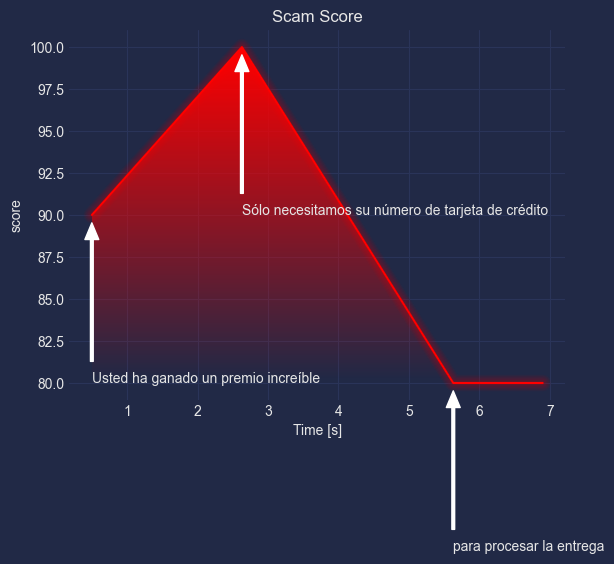

In [133]:
df_temp = phrases.copy()
df_temp.loc[len(df_temp.index)] = df_temp.iloc[-1]
df_temp.loc[len(df_temp.index) - 1, 'start_time'] = df_temp.loc[len(df_temp.index) - 1, 'end_time']
plot = sns.lineplot(data=df_temp, x = 'start_time', y = 'score', color = 'r').set(title='Scam Score')
for i in phrases.index:
    x = float(phrases.loc[i, 'start_time'])
    y = float(phrases.loc[i, 'score'])
    text = phrases.loc[i, 'phrase']
    _ = plt.annotate(text, xy=(x,y), xytext=(x, y - 10),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=10, width=2, color = 'white'))
plt.xlabel("Score")
plt.xlabel("Time [s]")
#plt.xlim(0,phrases.end_time.max())
mplcyberpunk.add_glow_effects(gradient_fill=True)

In [144]:

phrases['emoji'] = phrases['sentiment'].map(lambda x: '😃' if x == 'feliz' else '☹️' )

/var/folders/r4/g6b0q1650fdbyb5v7h56z8vr0000gn/T/ipykernel_71337/1549154056.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  _ = plt.annotate(phrase, xy=(x,y), xytext=(x, y - 10),
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.


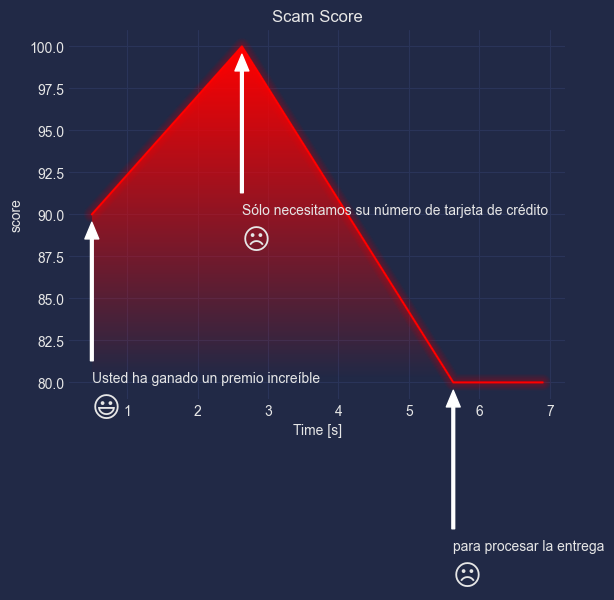

In [157]:
df_temp = phrases.copy()
df_temp.loc[len(df_temp.index)] = df_temp.iloc[-1]
df_temp.loc[len(df_temp.index) - 1, 'start_time'] = df_temp.loc[len(df_temp.index) - 1, 'end_time']
plot = sns.lineplot(data=df_temp, x = 'start_time', y = 'score', color = 'r').set(title='Scam Score')
for i in phrases.index:
    x = float(phrases.loc[i, 'start_time'])
    y = float(phrases.loc[i, 'score'])
    text = phrases.loc[i, 'emoji']
    phrase = phrases.loc[i, 'phrase']

    _ = plt.annotate(phrase, xy=(x,y), xytext=(x, y - 10),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=10, width=2, color = 'white'))
    
    _ = plt.annotate(text, xy=(x,y), xytext=(x, y - 12),
             fontname='Segoe UI Emoji', # this is the param added
        fontsize=20)
plt.xlabel("Score")
plt.xlabel("Time [s]")
#plt.xlim(0,phrases.end_time.max())
mplcyberpunk.add_glow_effects(gradient_fill=True)